In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

#from imutils import paths
from pathlib import Path
import os, sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

# Local modules
sys.path.append('../src')
from train import train_model
from visualize import imshow, visualize_model
from utils import unpickle, save_pickle
from transforms import makeDefaultTransforms
from data import ImageFolderWithPaths
from layer_feature_maps import extract_feature_maps

In [5]:
def load_class_names(dataset_path=''):
    names = {}
    with open(os.path.join(dataset_path, 'classes.txt')) as f:
        for line in f:
            pieces = line.strip().split()
            class_id = pieces[0]
            names[class_id] = ' '.join(pieces[1:])
    return names

In [8]:
# Script runtime options
root_dir = '..'  #'/home/jupyter/caltech_birds'
model = 'resnet152'
data_root_dir = os.path.join(root_dir, 'data_nabirds')
model_root_dir = os.path.join(root_dir, 'nabirds_models')
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images_sorted')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'na_birds_{}_full.pth'.format(model))

In [9]:
# Get data transforms
data_transforms = makeDefaultTransforms(img_crop_size=224, img_resize=256)

In [10]:
# Setup data loaders with augmentation transforms
image_datasets = {x: ImageFolderWithPaths(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}

class_labels = load_class_names(dataset_path=data_root_dir)
class_names = []
for class_id in image_datasets['test'].classes:
    class_names.append( '{} - {}'.format(class_id, class_labels[str(int(class_id))]) )
    
num_classes = len(class_names)

In [11]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


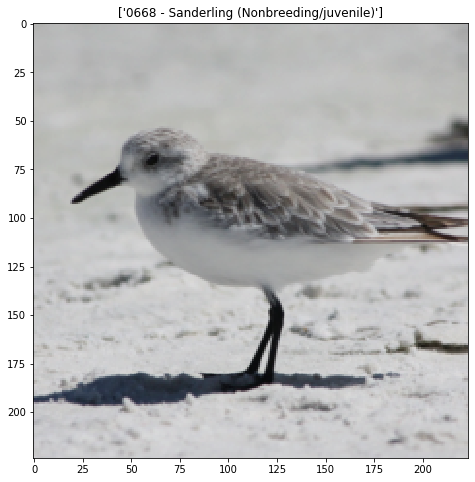

In [12]:
# Check the augmentations
# Get a batch of training data
inputs, classes, paths = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
# Load the best model from file
model_ = torch.load(model_file)

In [14]:
model_

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
fc_feature_extractions= []
def hook(module, input, output):
    fc_feature_extractions.append(output)

In [16]:
#model_.fc.register_forward_hook(hook)
model_.avgpool.register_forward_hook(hook)

In [17]:
feature_extractions_dict = extract_feature_maps(model=model_, dataloader=dataloaders['test'], fc_feature_extractions=fc_feature_extractions,device=device)

Commencing predictions and feature extraction minibatch..0..25..50..75..100..125..150..175..200..225..250..275..300..325..350..375..400..425..450..475..500..525..550..575..600..625..650..675..700..725..750..775..800..825..850..875..900..925..950..975..1000..1025..1050..1075..1100..1125..1150..1175..1200..1225..1250..1275..1300..1325..1350..1375..1400..1425..1450..1475..1500..1525..1550..1575..1600..1625..1650..1675..1700..1725..1750..1775..1800..1825..1850..1875..1900..1925..1950..1975..2000..2025..2050..2075..2100..2125..2150..2175..2200..2225..2250..2275..2300..2325..2350..2375..2400..2425..2450..2475..2500..2525..2550..2575..2600..2625..2650..2675..2700..2725..2750..2775..2800..2825..2850..2875..2900..2925..2950..2975..3000..3025..3050..3075..3100..3125..3150..3175..3200..3225..3250..3275..3300..3325..3350..3375..3400..3425..3450..3475..3500..3525..3550..3575..3600..3625..3650..3675..3700..3725..3750..3775..3800..3825..3850..3875..3900..3925..3950..3975..4000..4025..4050..4075..4100

In [18]:
save_pickle(feature_extractions_dict, '../nabirds_models/classification/{}/{}_feature_extractions.pkl'.format(model,model))

In [19]:
feature_extractions_dict['feature extractions'][0].shape

(1, 2048, 1, 1)

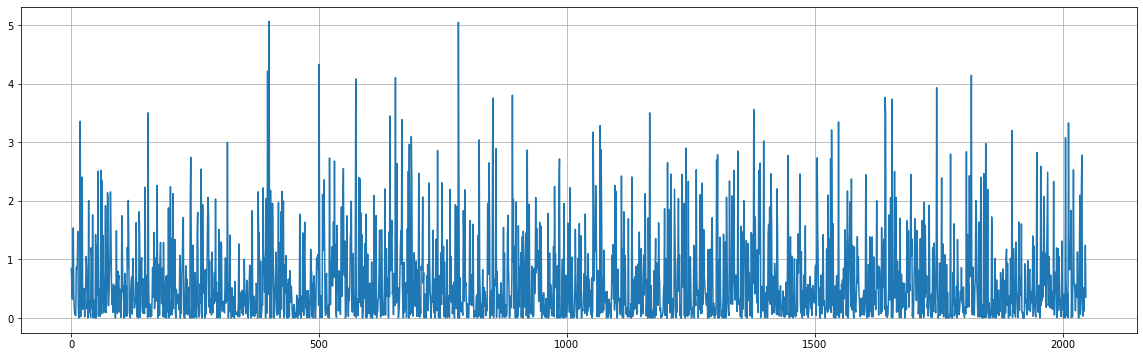

In [20]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0,feature_extractions_dict['feature extractions'][0].shape[1],1),
         feature_extractions_dict['feature extractions'][0].ravel())
plt.grid(True)
plt.show()